## Построение графа

In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests 
import time
import re
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [ ]:
access_token = "0906a3e80906a3e80906a3e8630a15a86c009060906a3e86d098518b9ef19be9b4e879a"
basket = "62065987" # Баскетбол | Кронверкские барсы | ИТМО
foot = "77511653" # Футбол | Кронверкские барсы | ИТМО

In [ ]:
def get_group_members(group_id, access_token):
    members = []
    offset = 0
    count = 1000
    while True:
        params = {
            "group_id": group_id,
            "access_token": access_token,
            "v": "5.131",
            "offset": offset,
            "count": count,
        }
        response = requests.get("https://api.vk.com/method/groups.getMembers", params=params)
        if response.status_code == 200:
            data = response.json()
            members.extend(data["response"]["items"])
            offset += count
            if offset >= data["response"]["count"]:
                break
            time.sleep(0.1)
        else:
            print(f"Ошибка {response.status_code}: {response.text}")
            break
    return members


In [ ]:
basket_members = get_group_members(basket, access_token)
foot_members = get_group_members(foot, access_token)

In [ ]:
common_members = set(foot_members) & set(basket_members)

print(f"Количество пользователей, подписанных на оба сообщества: {len(common_members)}")

Количество пользователей, подписанных на оба сообщества: 90


In [ ]:
import networkx as nx
import time
import collections
import numpy as np

In [ ]:
def get_friends_ids(user_id):
    params = {
          "user_id": user_id,
          "access_token": access_token,
          "v": "5.131",
    }
    
    json_response = requests.get('https://api.vk.com/method/friends.get' , params=params).json()
    count = 0
    if json_response.get('error'):
        if json_response.get('error')['error_msg'] == 'This profile is private':
          count += 1
        else:
          print(json_response.get('error'))
        return list(), count
    
    return json_response[u'response']['items'], count

In [ ]:
def get_friends_members(members):
    res = {}
    count = 0
    for member in members:
      friends, c = get_friends_ids(member)
      count += c
      res[member] = np.intersect1d(friends, members)
    print(f'Private profiles detected: {count} out of {len(members)}')  
    return res

In [ ]:
basket_members_friends = get_friends_members(basket_members)

Private profiles detected: 247 out of 1174


In [ ]:
foot_members_friends = get_friends_members(foot_members)

Private profiles detected: 149 out of 678


<ipython-input-12-45c0a18cf42e>:14: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos=networkx.nx_pydot.graphviz_layout(g,prog="neato")


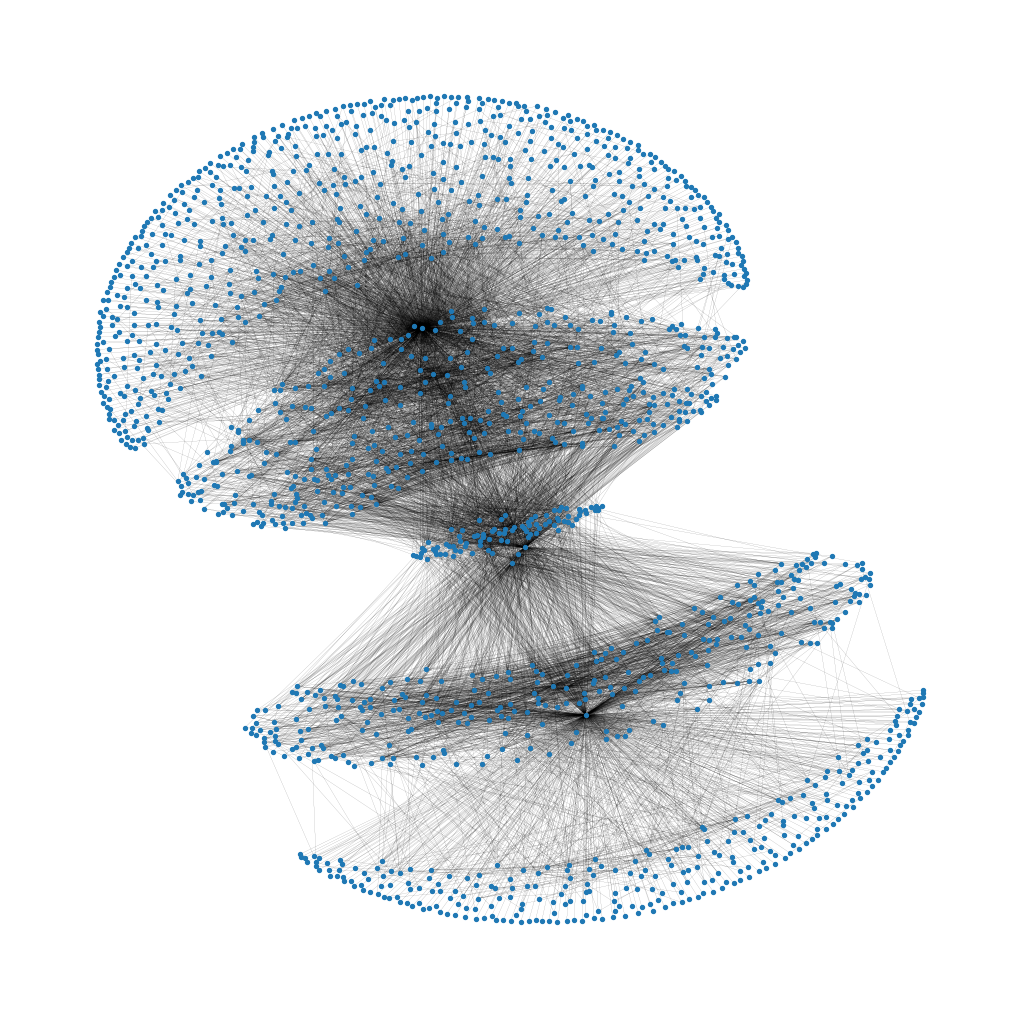

In [ ]:
g = nx.Graph(directed=False)
g.add_node('basket')
for member in basket_members_friends:
  g.add_node(member)
  g.add_edge('basket', member)
  for friend in basket_members_friends[member]:
    g.add_edge(member, friend)
g.add_node('foot')
for member in foot_members_friends:
  g.add_node(member)
  g.add_edge('foot', member)
  for friend in foot_members_friends[member]:
    g.add_edge(member, friend)
pos=nx.nx_pydot.graphviz_layout(g,prog="neato")
plt.figure(1,figsize=(10,10)) 
nx.draw(g, pos, node_size=8, with_labels=False, width=0.06)
plt.show()

## Задание 1

In [ ]:
betweenness_centrality = nx.betweenness_centrality(g)

# сортируем узлы по убыванию центральности
sorted_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]
# выводим результаты
for node in sorted_nodes:
    print(f"Узел {node} имеет центральность {betweenness_centrality[node]}")

Узел basket имеет центральность 0.6646921005067002
Узел foot имеет центральность 0.3311585217781982
Узел 222382111 имеет центральность 0.10692859255460435
Узел 1111374 имеет центральность 0.039910113092380045
Узел 174840518 имеет центральность 0.023187508936327858
Узел 998365 имеет центральность 0.01601680490480588
Узел 17339856 имеет центральность 0.013552969785308486
Узел 343693752 имеет центральность 0.012439881032439705
Узел 2070090 имеет центральность 0.009667578650401656
Узел 157062335 имеет центральность 0.006105071013750931


In [ ]:
import pandas as pd

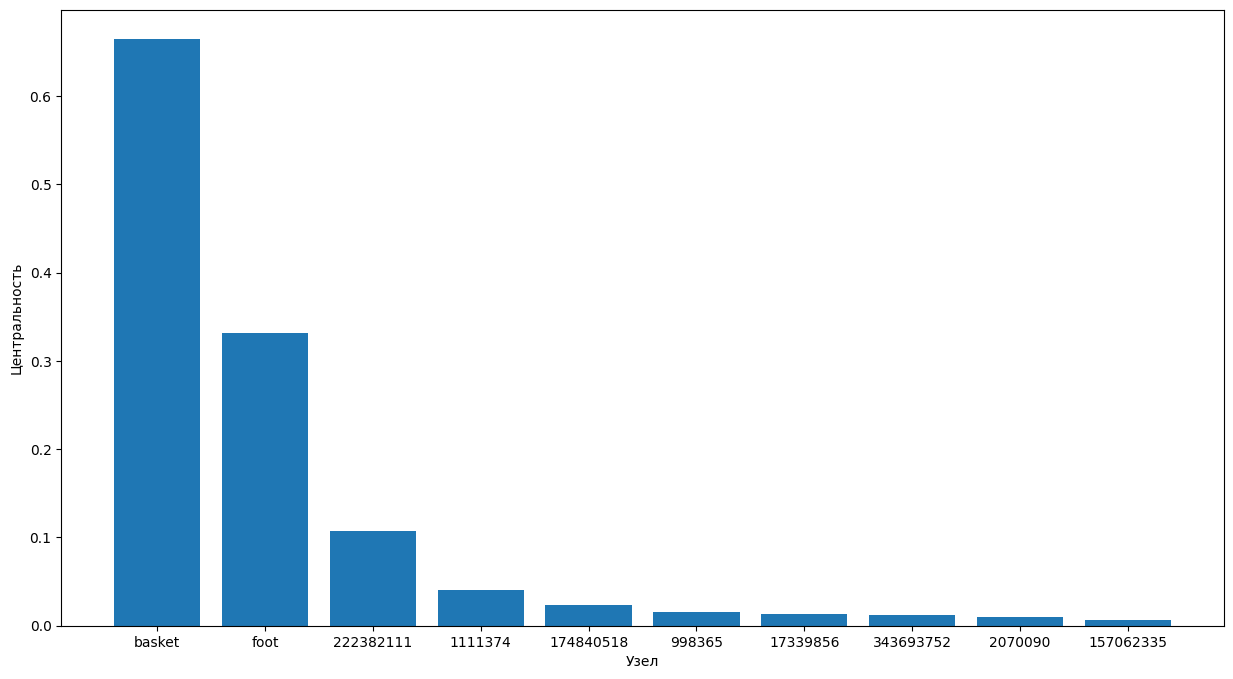

In [ ]:
# строим график
df = pd.DataFrame([(node, betweenness_centrality[node]) for node in sorted_nodes], columns=['x','y'])
df['x'] = df['x'].astype(str)
df['y'] = df['y'].astype(float)


plt.figure(figsize=(15, 8))
plt.bar(df['x'], df['y'])
plt.xlabel('Узел')
plt.ylabel('Центральность')
plt.show()

## Задание 2

In [ ]:
density = nx.density(g)

print("Плотность графа:", density)

Плотность графа: 0.005993057082920141


## Задание 3

In [ ]:
if nx.is_directed(g):
    if nx.is_weakly_connected(g):
        print('Граф является направленным и состоит из одной компоненты слабой связности.')
    else:
        print('Граф является направленным и состоит из нескольких компонент.')
else:
    if nx.is_connected(g):
        print('Граф является ненаправленным и связным.')
    else:
        print('Граф является ненаправленным и состоит из нескольких компонент.')

Граф является ненаправленным и связным.


## Задание 4

In [ ]:
# вычисляем степень каждого узла
degree = dict(g.degree())

# выводим максимальное, минимальное и среднее значение степени узлов
max_degree = sorted(degree.values())[-3]
min_degree = min(degree.values())
avg_degree = sum(degree.values()) / len(degree)

print(f"Максимальная степень узлов: {max_degree}")
print(f"Минимальная степень узлов: {min_degree}")
print(f"Средняя степень узлов: {avg_degree}")

Максимальная степень узлов: 393
Минимальная степень узлов: 1
Средняя степень узлов: 10.565759637188208


## Задание 5

In [ ]:
!pip install -U community

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import community.community_louvain as community_louvain
import community

partition = community_louvain.best_partition(g)
modularity = community_louvain.modularity(partition, g)

print(f"Модулярность графа: {modularity}")

Модулярность графа: 0.5419689734533721
